In [3]:
import h5py as h5
import arepo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d
from numba import njit
from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u

basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/Mgdec/'

import sys
sys.path.append(basepath+'note/')

import illustris_python as il
TNGbase = '/n/holylfs05/LABS/hernquist_lab/IllustrisTNG/Runs/L35n2160TNG/output/'

from lowda import load_galaxy
import lowda as lwd
from scipy.spatial import KDTree

In [4]:
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble=r"""
\usepackage{amsmath}
""")
# mpl.rcParams.update({'font.size': 22})
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
# color palette
tb_c = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f',
        '#edc948', '#b07aa1', '#ff9da7', '#9c755f', '#bab0ac']

columnwidth = 242.26653 / 72.27 # converts pts to inches
textwidth = 513.11743 / 72.27

mpl.rcParams.update({'font.size': 8})

In [5]:
def get_time(time, redshift=False, 
             Omega0=0.3089, 
             OmegaLambda=0.6911,
             HubbleParam=0.6774):
    HUBBLE = 3.2407789e-18
    SEC_PER_MEGAYEAR = 3.15576e13
    
    if redshift:
        a = 1./(1.+time)
    else:
        a = time
    
    fac = 2. / (3. * np.sqrt(OmegaLambda))
    ans = fac * np.arcsinh(np.sqrt(a**3 * OmegaLambda/Omega0))

    ans /= HUBBLE * HubbleParam
    ans /= SEC_PER_MEGAYEAR * 1000
    
    return ans

In [6]:
meta = {}
meta['snap_list'] = np.arange(100)
meta['header'] = []
meta['redshift'] = []
meta['scale_factor'] = []
meta['time'] = []
meta['time_lookback'] = []

t0 = get_time(1.)

for i in meta['snap_list']:
    header = arepo.Snapshot(TNGbase, i, onlyHeader=True)
    
    meta['header'].append(header)
    meta['redshift'].append(header.Redshift)
    meta['scale_factor'].append(header.Time)
    meta['time'].append(get_time(header.Time))
    meta['time_lookback'].append(t0 - get_time(header.Time))

meta['redshift'] = np.array(meta['redshift'])
meta['scale_factor'] = np.array(meta['scale_factor'])
meta['time'] = np.array(meta['time'])
meta['time_lookback'] = np.array(meta['time_lookback'])

In [7]:
@njit
def rodrigues_formula(k, v, theta):
    N = v.shape[0]
    v_rot = np.zeros(np.shape(v))
    
    ctheta = np.cos(theta)
    stheta = np.sin(theta)
    
    for i in range(N):
        v_rot[i] = v[i] * ctheta + np.cross(k, v[i]) * stheta + k * (np.dot(k, v[i])) * (1-ctheta)
    
    return v_rot

In [75]:
def get_rot_pos_vel(subID, snapnum, ptype=4, rhalf_fac=2,
                    k=None, theta=None, return_k_theta=False):
    # get COM, COMV, and ang mom of stars
    subhalo = il.groupcat.loadSingle(TNGbase, snapnum, subhaloID=subID)
    grpID = subhalo['SubhaloGrNr']
    snap = {}
    snap[4] = il.snapshot.loadHalo(TNGbase, snapnum, grpID, 4)
    if ptype != 4:
        snap[ptype] = il.snapshot.loadHalo(TNGbase, snapnum, grpID, ptype)
    
    COM = subhalo['SubhaloPos']
    pos = snap[4]['Coordinates'] - COM
    r = np.linalg.norm(pos, axis=1)
    
    rhalf = subhalo['SubhaloHalfmassRadType'][4]

    in_rhalf = r < 2 * rhalf
    is_star = snap[4]['GFM_StellarFormationTime'] > 0
    is_star_in_rhalf = np.logical_and(is_star, in_rhalf)
    
    vel_in_rhalf = snap[4]['Velocities'][is_star_in_rhalf]
    mass_in_rhalf = snap[4]['Masses'][is_star_in_rhalf]
    COMV = np.average(vel_in_rhalf, axis=0, weights=mass_in_rhalf)
    
    vel = snap[4]['Velocities'] - COMV
    
    ang = np.cross(pos[is_star_in_rhalf], vel[is_star_in_rhalf])
    ang *= mass_in_rhalf.reshape(-1, 1)
    ang = np.sum(ang, axis=0)
    
    ang_mom = ang

    angmom_dir = ang_mom/np.linalg.norm(ang_mom)
    if theta is None:
        theta = np.arccos(np.dot(angmom_dir, np.array([0, 0, 1])))
    if k is None:
        k = np.cross(ang_mom, np.array([0, 0, 1.]))
        k /= np.linalg.norm(k)
    
    pos = snap[ptype]['Coordinates'] - COM
    vel = snap[ptype]['Velocities'] - COMV
    mass = snap[ptype]['Masses']
    
    pos_rot = rodrigues_formula(k, pos.astype(np.float64), theta)
    vel_rot = rodrigues_formula(k, vel.astype(np.float64), theta)
    
    pos_rot *= meta['header'][snapnum].Time/meta['header'][snapnum].HubbleParam
    vel_rot *= np.sqrt(meta['header'][snapnum].Time)
    
    if return_k_theta:
        return k, theta
    
    return pos_rot, vel_rot, mass

In [65]:
def gadget_spline(u, h=1, M=1):
    pre = M * 8 / (np.pi * h**3)
    ans = np.zeros_like(u)
    ans0 = 1 - 6*u**2 + 6 * u**3
    ans1 = 2 * (1-u)**3
    
    key0 = u <= 0.5
    key1 = np.logical_and(u > 0.5, u <= 1)
    ans[key0] = ans0[key0]
    ans[key1] = ans1[key1]
    
    ans *= pre
    
    return ans

def get_sigma_interp():
    blist = np.linspace(0, 1, 1024)
    slist = np.linspace(-1, 1, 1024)
    bgrid, sgrid = np.meshgrid(blist, slist, indexing='ij')
    
    rgrid = np.sqrt(bgrid**2 + sgrid**2)
    Wgrid = gadget_spline(rgrid, 1)
    
    sigma = np.trapz(Wgrid, slist, axis=1)
    return blist, sigma

# @njit
def sum_kernel_surface_dens(xpts, ypts, x, y, M, h, bint, sigmaint):
    
    pos = np.transpose([x, y])
    sigma = np.zeros(len(xpts)*len(ypts))
    
    xgrid, ygrid = np.meshgrid(xpts, ypts, indexing='ij')
    grid = np.transpose([xgrid.ravel(), ygrid.ravel()])
    
    tree_grid = KDTree(grid)

    # now do a ball query
    ball_idx = tree_grid.query_ball_point(pos, h)
    
    ball_idx_filter = [b for b in ball_idx if b]
    
    part_idx = np.concatenate([[i] * len(b) for i,b in enumerate(ball_idx) if b])
    ball_idx = np.concatenate(ball_idx_filter)
    
    # now get impact parameter
    b = np.linalg.norm(pos[part_idx] - grid[ball_idx], axis=1)
    sigma_ = M[part_idx]/h[part_idx]**3 * np.interp(b/h[part_idx], bint, sigmaint)
    sigma = np.bincount(ball_idx, weights=sigma_, minlength=len(xpts)*len(ypts))

    sigma = np.reshape(sigma, (len(xpts), len(ypts)))

    return sigma

def get_star_maps(subID, snapnum, L, Nres, k=None, theta=None, ptype=4):
    # get 
    
    pos, vel, mass = get_rot_pos_vel(subID, snapnum, k=k, theta=theta, ptype=ptype)

    dL = L/Nres
    # xpts = np.arange(-L/2, L/2, dL) + dL/2.
    # ypts = np.arange(-L/2, L/2, dL) + dL/2.
    # zpts = np.arange(-L/2, L/2, dL) + dL/2.
    
    xbins = np.arange(-L/2, L/2.+dL, dL)
    ybins = np.arange(-L/2, L/2.+dL, dL)
    
    Hxy, _, _, _ = binned_statistic_2d(pos[:,0], pos[:,1], mass/dL/dL,
                                     statistic='sum', bins=[xbins, ybins])
    
    Hxz, _, _, _ = binned_statistic_2d(pos[:,0], pos[:,2], mass/dL/dL,
                                     statistic='sum', bins=[xbins, ybins])
    
    # get softening lengths
    # tree = KDTree(pos)
    # h, _ = tree.query(pos, 33)
    # h = h[:,-1]
    
    # bint, sigmaint = get_sigma_interp()
    # Hxy = sum_kernel_surface_dens(xpts, ypts, x, y, mass, h, bint, sigmaint)
    # Hxz = sum_kernel_surface_dens(xpts, zpts, x, z, mass, h, bint, sigmaint)
    
    return Hxy, Hxz

In [74]:
subhalo = il.groupcat.loadSingle(TNGbase, snap, subhaloID=subID_atsnap)


87

In [60]:
subID_atsnap = 172175
snap = 40
treeMPB = il.sublink.loadTree(TNGbase, snap, subID_atsnap, onlyMPB=True)

k, theta = get_rot_pos_vel(subID_atsnap, snap, return_k_theta=True)

[ 0.69703852  0.71703369 -0.        ]
[ 0.69703852  0.71703369 -0.        ]


100%|██████████| 5/5 [00:54<00:00, 10.97s/it]


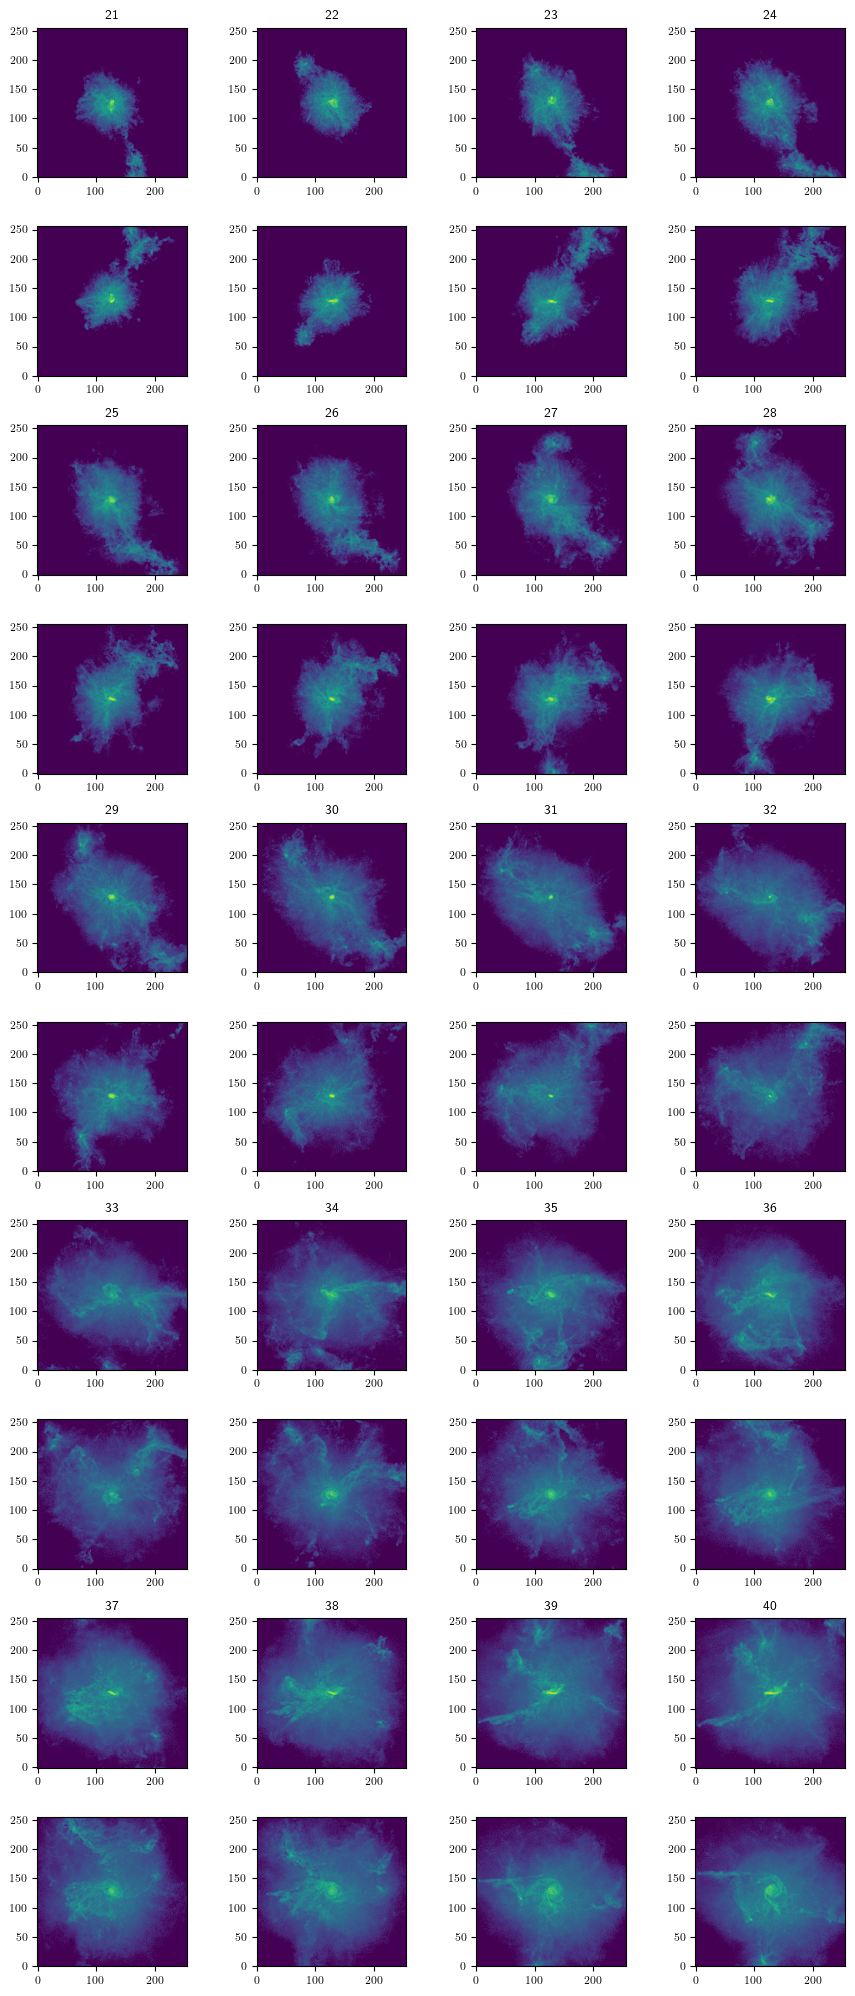

In [77]:
fig, axs = plt.subplots(10, 4, figsize=(9, 20))

L = 200
Nres = 256

vmax=1e-1
vmin=10.**(-4.5)

snap_list = np.arange(21, 41)
ct = 0
for i in tqdm(range(0, 10, 2)):
    for j in range(4):
        snap_ = snap_list[ct]
        key = np.where(treeMPB['SnapNum'] == snap_)[0]
        subID = treeMPB['SubfindID'][key][0]
        Hxy, Hxz = get_star_maps(subID, snap_, L, Nres, k=k, theta=theta, ptype=0)
        
        Hxz[Hxz<vmin] = vmin
        Hxy[Hxy<vmin] = vmin
        
        axs[i][j].imshow(Hxz.T, origin='lower', norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax))
        axs[i+1][j].imshow(Hxy.T, origin='lower', norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax))
        
        axs[i][j].set_title(str(snap_))
        
        ct += 1

fig.tight_layout()
        

In [21]:
Hxy, Hxz = get_star_maps(172175, 40, 60, 256)

/tmp/ipykernel_812682/498718276.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.hist(np.log10(Hxy).ravel(), bins=np.linspace(-6, 0, 100));


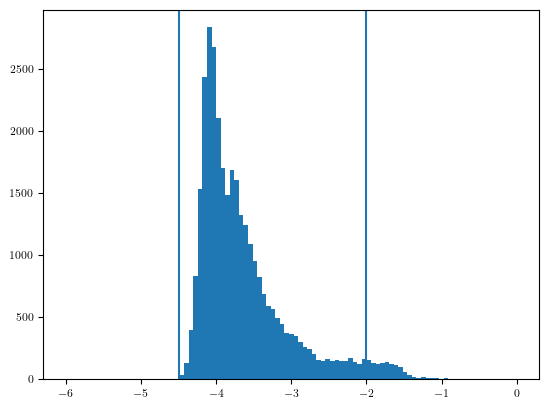

In [34]:
plt.hist(np.log10(Hxy).ravel(), bins=np.linspace(-6, 0, 100));
plt.axvline(-4.5)
plt.axvline(-2)

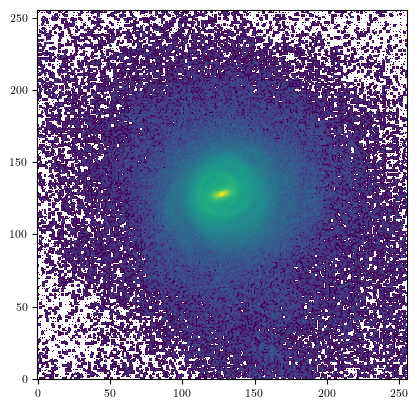

In [30]:
plt.imshow(Hxy.T, origin='lower', norm=mpl.colors.LogNorm())

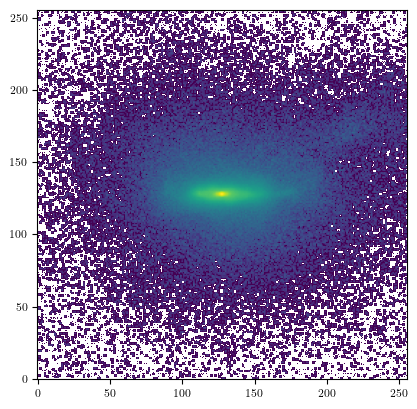

In [31]:
plt.imshow(Hxz.T, origin='lower', norm=mpl.colors.LogNorm())

In [15]:
%prun pos, vel, mass = get_rot_pos_vel(172175, 40)

In [20]:
r = np.linalg.norm(pos, axis=1)
print(len(r))
print(np.sum(r < 30))

1044445
1014553
